# LED substitution stimuli

In [1]:
import dreye
import numpy as np
import pandas as pd
from itertools import product

In [2]:
dreye.__version__

'0.2.0dev1'

## Get dummy LED measurements and a photoreceptor model

In [3]:
wls = np.arange(300, 651)

In [7]:
measured_spectra = dreye.create_measured_spectra_container(
    [370, 460, 560], wavelengths=wls, names=['uv', 'cyan', 'lime'], 
    intensity_bounds=(0, 1000)
)
led_cmap = dict(zip(measured_spectra.names, ['black', 'gray', 'grey']))

## Spectra of LEDs used for fitting

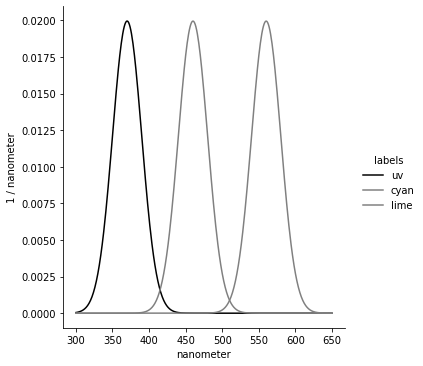

In [8]:
measured_spectra.normalized_spectra.plot(palette=led_cmap)

In [9]:
# intensity range of LEDs
measured_spectra.intensity_bounds

(array([0., 0., 0.]), array([1000., 1000., 1000.]))

## Dichromatic linear photoreceptor model

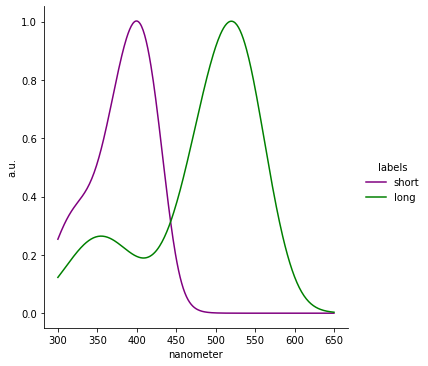

In [11]:
cmap = {'short': 'purple', 'long': 'green'}

photoreceptor_model = dreye.create_photoreceptor_model(
    np.array([400, 520]), 
    wls, 
    labels=list(cmap), 
    name='opsins'
)
photoreceptor_model.sensitivity.plot(palette=cmap)


## Setup Led Substitution stimulus model

In [12]:
stimuli_model = dreye.LedSubstitutionFit(
    photoreceptor_model=photoreceptor_model, 
    measured_spectra=measured_spectra, 
    
    unidirectional=True,  
    # only allow increases or decreases, when 
    # simulating an increase or decrease of an LED respectively
    
    keep_proportions=False, 
    # whether to keep the porportions of the LEDs across intensities
    
    # bg_ints=np.ones(3), 
    # intensity of LEDs for the background if wanted, default to 0 if rtype is absolute or diff else it is 1
    
    rtype='absolute', 
    fit_weights=np.array([1, 2]), 
    ignore_bounds=True
)

### Construct X

In [13]:
led_idcs = [1]  # indices of different LEDs to simulate
led_intensities = np.arange(1, 11, 1) # desired intensities of the LEDs to simulate
X = np.array(list(product(led_idcs, led_intensities)))

In [14]:
stimuli_model.fit(X)

LedSubstitutionFit(fit_weights=array([1, 2]), ignore_bounds=True,
                   measured_spectra=MeasuredSpectraContainer([[0.0 0.004849368383414684 0.009698736766829369 ... 0.03394557868390279  0.038794947067317474 0.043644315450732156] [0.0 0.005769575261266365 0.01153915052253273 ... 0.04038702682886456  0.04615660209013092 0.05192617735139728] [0.0 0.006847259274136591 0.0136945...5098424] [0.0 0.00011106591628946158 0.00022213183257892315 ...  0.0007774614140262311 0.0008885273303156926 0.0009995932466051543] [0.0 8.879886474422048e-05 0.00017759772948844097 ...  0.0006215920532095435 0.0007103909179537639 0.0007991897826979844]] microspectral_E_Q),
                   photoreceptor_model=LinearPhotoreceptor('short', 'long'),
                   rtype='absolute', unidirectional=True)

In [15]:
stimuli_model.sample_scores()

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [20]:
df = stimuli_model.fitted_intensities_df_.copy()
df.columns.name = 'led_names'
df = df.stack()
df.name = 'led_intensities'
df = df.reset_index()
df.head()

,led,simulate,rel_led_int,rtype,fitted_short,fitted_long,led_names,led_intensities
0,cyan,True,1.001,absolute,0.171955,0.497468,uv,0.234447
1,cyan,True,1.001,absolute,0.171955,0.497468,cyan,0.000000
2,cyan,True,1.001,absolute,0.171955,0.497468,lime,0.726589
3,cyan,False,1.001,absolute,0.171955,0.497468,uv,0.000000
4,cyan,False,1.001,absolute,0.171955,0.497468,cyan,1.001000


In [21]:
import seaborn as sns

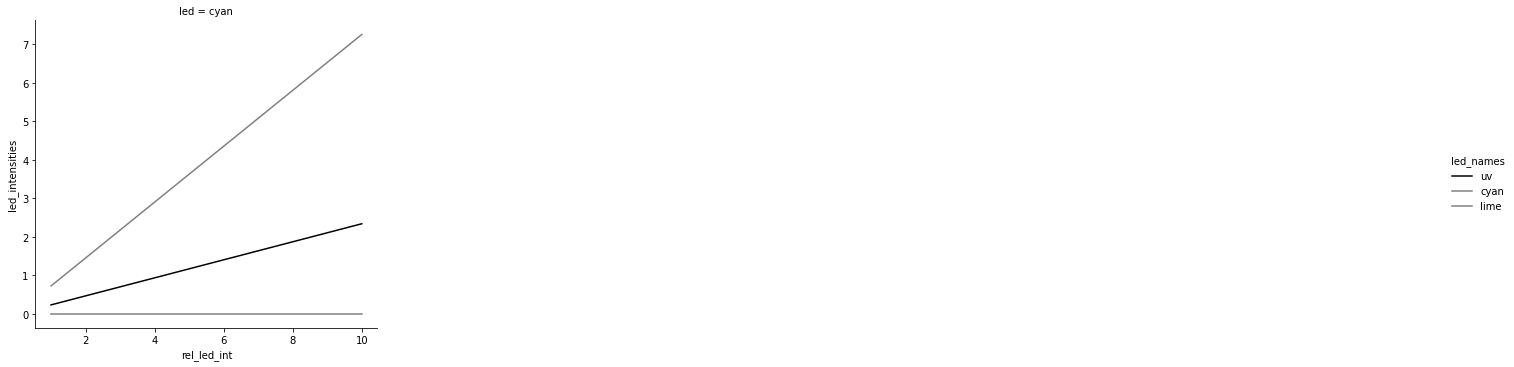

In [22]:
sns.relplot(
    data=df[df['simulate']],
    x='rel_led_int', 
    y='led_intensities', 
    hue='led_names', 
    col='led', 
    col_wrap=4, 
    ci=None,
    kind='line', 
    palette=led_cmap
)

In [24]:
selected_fit = stimuli_model.fitted_intensities_df_.iloc[:2]
selected_fit

uv   cyan  \
led  simulate rel_led_int rtype    fitted_short fitted_long                    
cyan True     1.001       absolute 0.171955     0.497468     0.234447  0.000   
     False    1.001       absolute 0.171955     0.497468     0.000000  1.001   

                                                                 lime  
led  simulate rel_led_int rtype    fitted_short fitted_long            
cyan True     1.001       absolute 0.171955     0.497468     0.726589  
     False    1.001       absolute 0.171955     0.497468     0.000000

In [27]:
fitted_spectra = dreye.Signals(
    measured_spectra.normalized_spectra.magnitude * selected_fit.sum(axis=0).to_numpy(), 
    wls, 
    units=None, 
    domain_units='nm',
    labels=measured_spectra.names, 
    name='LEDs'
)
fitted_spectra /= fitted_spectra.max()

In [28]:
signals = dreye.SignalsContainer(
    [photoreceptor_model.sensitivity, fitted_spectra]
)

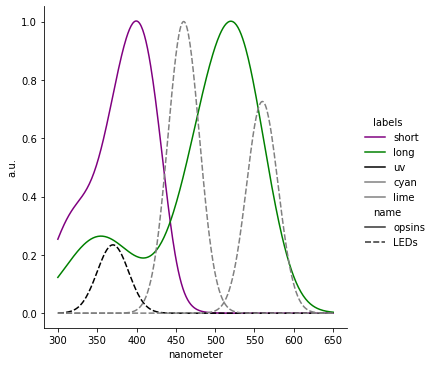

In [29]:
signals.plot(palette=dict(**led_cmap, **cmap), style='name', col=None)

In [30]:
qs = selected_fit.index.to_frame(False).set_index('simulate')[list(map(lambda x: 'fitted_' + x, cmap))]
qs.columns.name = 'opsin'
qs = qs.stack()
qs.name = 'q'
qs = qs.reset_index()
qs['opsin'] = qs['opsin'].str.replace('fitted_', '')
qs.loc[qs['simulate'], 'led'] = 'uv+lime'
qs.loc[~qs['simulate'], 'led'] = 'cyan'

<AxesSubplot:xlabel='led', ylabel='q'>

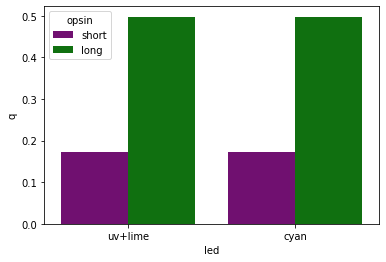

In [31]:
sns.barplot(
    data=qs, 
    hue='opsin', 
    y='q',
    x='led', 
    palette=cmap
)

In [32]:
from dreye.datasets import load_granada

In [33]:
daylight_spectra = load_granada()

In [36]:
mean_daylight = daylight_spectra.groupby('wavelengths')['microspectralphotonflux'].mean()
mean_daylight = dreye.Signal(mean_daylight, domain_units='nm', units='uE', name='daylight')

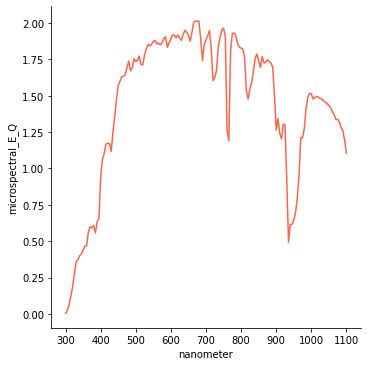

In [37]:
mean_daylight.plot(color='tomato')

In [38]:
X = photoreceptor_model.excitation(mean_daylight, return_units=False)

In [39]:
model = dreye.IndependentExcitationFit(
    photoreceptor_model=photoreceptor_model, 
    measured_spectra=measured_spectra, 
    ignore_bounds=False
)

In [40]:
model.fit(X)

IndependentExcitationFit(ignore_bounds=False,
                         measured_spectra=MeasuredSpectraContainer([[0.0 0.004849368383414684 0.009698736766829369 ... 0.03394557868390279  0.038794947067317474 0.043644315450732156] [0.0 0.005769575261266365 0.01153915052253273 ... 0.04038702682886456  0.04615660209013092 0.05192617735139728] [0.0 0.006847259274136591 0.013694518548273181 ... 0.04...85 0.0011085580626754154 0.0012471278205098424] [0.0 0.00011106591628946158 0.00022213183257892315 ...  0.0007774614140262311 0.0008885273303156926 0.0009995932466051543] [0.0 8.879886474422048e-05 0.00017759772948844097 ...  0.0006215920532095435 0.0007103909179537639 0.0007991897826979844]] microspectral_E_Q),
                         photoreceptor_model=LinearPhotoreceptor('short', 'long'))

In [41]:
model.sample_scores()

array([1.])

In [42]:
excitations = pd.DataFrame(
    np.vstack([X, model.fitted_excite_X_]), 
    columns=list(cmap), 
    index=['daylight', '+'.join(led_cmap)]
)
excitations.columns.name = 'opsin'
excitations.index.name = 'spectrum'
excitations = excitations.stack()
excitations.name = 'q'
excitations = excitations.reset_index()
excitations

,spectrum,opsin,q
0,daylight,short,70.804786
1,daylight,long,205.164158
2,uv+cyan+lime,short,70.804786
3,uv+cyan+lime,long,205.164158


<AxesSubplot:xlabel='spectrum', ylabel='q'>

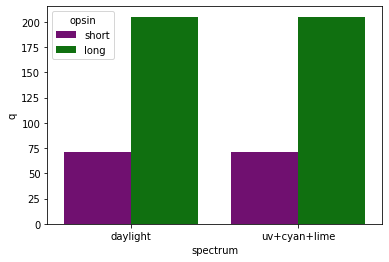

In [43]:
sns.barplot(
    data=excitations, 
    hue='opsin', 
    y='q',
    x='spectrum', 
    palette=cmap
)

In [45]:
fitted_spectra = dreye.Signals(
    measured_spectra.normalized_spectra.magnitude * model.fitted_intensities_[0], 
    wls, 
    units='uE', 
    domain_units='nm',
    labels=measured_spectra.names, 
    name='LEDs'
)

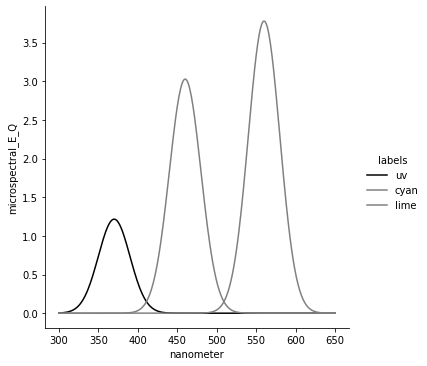

In [46]:
fitted_spectra.plot(palette=led_cmap)

In [47]:
all_spectra = fitted_spectra.labels_concat(mean_daylight)

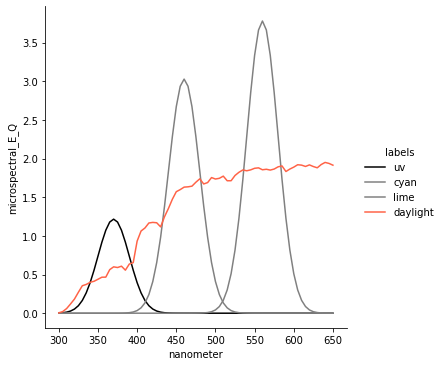

In [48]:
all_spectra.plot(
    palette=dict(**led_cmap, daylight='tomato'),
    # linestyle='--'
)